# Amazon Fine Foods Review Analysis

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 Number of users: 256,059 Number of products: 74,258 Timespan: Oct 1999 - Oct 2012 Number of Attributes/Columns in data: 10

Attribute Information:

    Id - Row Id
    ProductId - unique identifier for the product
    UserId - unqiue identifier for the user
    ProfileName - Profile name of the user
    HelpfulnessNumerator - number of users who found the review helpful
    HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    Score - rating between 1 and 5
    Time - timestamp for the review
    Summary - brief summary of the review
    Text - text of the review


In [1]:
# Import the relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
import string
from nltk.corpus import stopwords 
import string
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
import warnings
warnings.filterwarnings('ignore')

Act_data = Actual data that is available in dataset

In [2]:
# Loading the dataset
Act_data = pd.read_csv('/home/kirankumar_yeddala/Reviews.csv')
print("Actual Shape of data:",Act_data.shape)
#Structure of 5 rows of data
Act_data.head()

Actual Shape of data: (568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
Act_data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


My average rating of all the dataset is approx 4.18 out of (1 to 5)

# Data Cleaning 

In [4]:
# Removing the data for which score is not equal to 3 
Act_data = Act_data[Act_data['Score'] != 3]
Act_data.shape

(525814, 10)

In [5]:
# Now splitting the data based on score as Positive or Negative
# If my score is above 3 it is positive otherwise it is Negative.
# As the dataset contains more than 50000 plus records, due to computational time we will work on 15000K records
sample_act_data = Act_data.head(5000)
sample_act_data['Score'] = ['Positive' if (int(score)>3) else 'Negative' for score in sample_act_data['Score']]


In [6]:
#Checking after converting the Score values to Positive or Negative
sample_act_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
#Percentage of Scores after modification
sample_act_data['Score'].value_counts(normalize = True)

Positive    0.8374
Negative    0.1626
Name: Score, dtype: float64

With the sample dataset of 5000 positive score is 83.74% and Negative score is 16.26%

Now Deleting the Duplicate entries and sorting the considered dataset for further processing

In [8]:
sorted_data = sample_act_data.sort_values('ProductId', ascending=True, inplace=False, kind='quicksort', na_position='last')

final_data = sample_act_data.drop_duplicates(subset = {'UserId','ProfileName','Time','Text'}, keep='first', inplace=False)

# Data Preprocessing

Methods used in Preprocessing
1. Stop words removal
2. Removal of HTML tags
3. Stemming using porter stemming - removing affixes from words 
4. Tokenizing - Splitting sentences and words from the body of text
5. Lemmatization - synonym or a different word with the same meaning

In [9]:
#nltk.download('stopwords')
#set of stop words
stop = set(stopwords.words('english'))

#Initializing snowball stemmer
snow_stem = nltk.stem.SnowballStemmer('english')

#function to clean the word of any html-tags
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [10]:
#Preprocessing the text like cleaning HTML tags, removal of stopwords, punctuations removal...
Preproc_text = []
cleanedtext = []
for sent in final_data['Text']:
    row_text=[]
    sent = cleanhtml(sent)
    for words in sent.split():
        clean_word = cleanpunc(words)
        if (clean_word.isalpha()) & (len(clean_word)>2):
            if(clean_word.lower() is not stop):
                finalword = (snow_stem.stem(clean_word.lower()).encode('utf8'))
                row_text.append(finalword)
            else:
                continue
        else:
            continue
        
    Preproc_text.append( b' '.join(row_text).decode('utf8'))



# BOW

The bag-of-words model is a way of representing text data when modeling text with machine learning algorithms

The bag-of-words model is simple to understand and implement and has seen great success in problems such as 
language modeling and document classification.

In a nutshell, A bag-of-words is a representation of text that describes the occurrence of words within a document. 
It involves two things:

    1. A vocabulary of known words.
    2. A measure of the presence of known words.


In [11]:
#Converting the cleaned text to sparse matrix
count_vec = CountVectorizer()
bow = count_vec.fit_transform(Preproc_text)

In [12]:
#converting sparse matrix to dense matrix
bow = bow.todense()

Now applying BOW data on TSNE

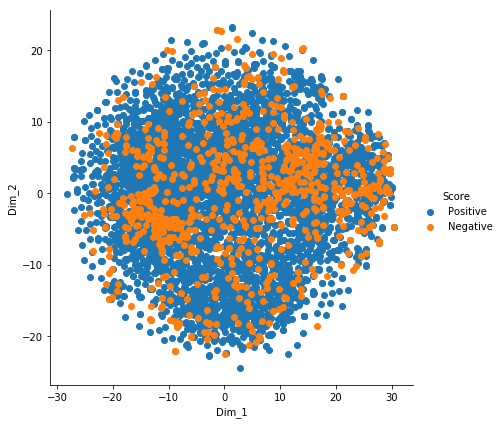

In [13]:
#Applying TSNE with default perplexity and iterations
bow_TSNE = TSNE(n_components = 2, random_state = 0).fit_transform(bow)
label = final_data['Score']
tsne_data = np.vstack((bow_TSNE.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'Score'))
sns.FacetGrid(tsne_df, hue = 'Score', size = 6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

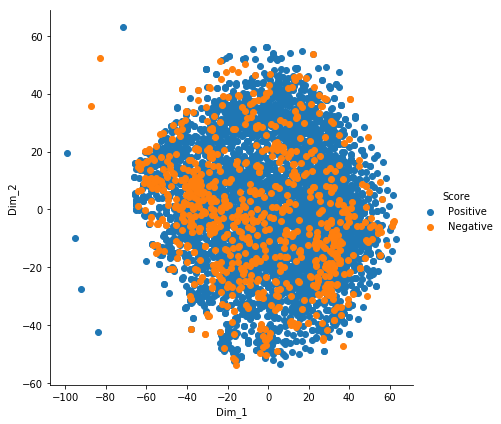

In [14]:
bow_TSNE = TSNE(perplexity = 10, n_iter = 1000).fit_transform(bow)
label = final_data['Score']
tsne_data = np.vstack((bow_TSNE.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'Score'))
sns.FacetGrid(tsne_df, hue = 'Score', size = 6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

Increae in Iterations does not produce any favourable solution as positive and negative are still overlapping

# TF-IDF

TF-IDF stands for term frequency-inverse document frequency. TF-IDF weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.

Term_frequency(TF) = (number of times word occur in document) / (Total number of words in the document).

Inverse_Document_freqency(IDF) = log((total number of documents) / In which documents a word occurs))

               So, TF-IDF(word) = TF(wor) * IDF(word)



In [12]:
#Vectorize the data
tfidf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf = tfidf_vect.fit_transform(Preproc_text)

In [13]:
#Converting from sparse matrix to dense matric
tfidf = tfidf.todense()

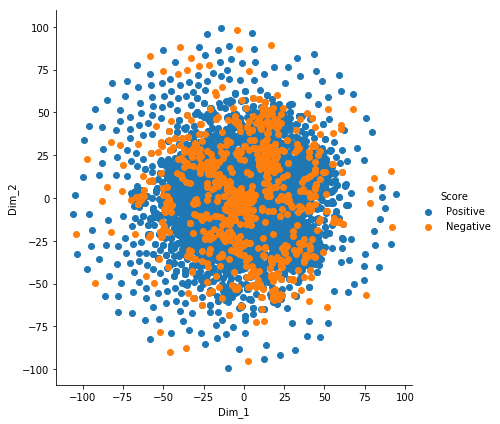

In [13]:
#Plotting the tfidf with default iterations
tfidf_TSNE = TSNE(n_components = 2, random_state = 0).fit_transform(tfidf)
label = final_data['Score']
tsne_data = np.vstack((tfidf_TSNE.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'Score'))
sns.FacetGrid(tsne_df, hue = 'Score', size = 6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# W2V and AvgW2V 

w2v --> It considers semantic meaning of a sentence/word.
        It learns all relationships automatically from rawtext

Avgw2v --> It will calculate the weighted schemas of each word to the total no. of words

In [15]:
#Splitting each sentence in to words
sent_words = []
for sent in Preproc_text:
    sent_words.append(sent.split())

In [16]:
#Converting each word into vector
from gensim.models import Word2Vec
w2v = Word2Vec(sent_words,min_count=5,size=50,workers=4)

In [17]:
#fining w2v_words
w2v_words = list(w2v.wv.vocab)

In [18]:
#Avg_W2V for all Reviews
avg_w2vs = []
for sent in Preproc_text:
    #initializing number of words
    n_words = 0
    #initializing vector of size of 50
    sent_vec = np.zeros(50)
    for word in sent.split():
        if word in w2v_words:
            #creating for each word is an vector
            vec = w2v.wv[word]
            sent_vec += vec
            n_words += 1
    if n_words != 0:
        sent_vec /= n_words
        avg_w2vs.append(sent_vec)

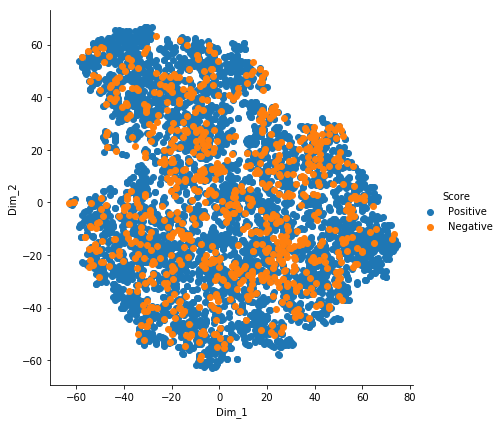

In [18]:
w2v_tsne = TSNE(n_components = 2, random_state = 0).fit_transform(avg_w2vs)
label = final_data['Score']
tsne_data = np.vstack((w2v_tsne.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'Score'))
sns.FacetGrid(tsne_df, hue = 'Score', size = 6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# TFIDF-W2V

It will considers the term frequency and w2v of each word to the sum of all the term frequencies

tfidf-w2v = [t1*(w2v(w1)) + t2*(w2v(w2))+-----]/t1+t2+-----

In [19]:
features = tfidf_vect.get_feature_names()
tfidf_w2vs = []
row = 0
for sent in Preproc_text:
    sent_vec = np.zeros(50)
    tfidf_sum = 0
    for word in sent.split():
        if(word in w2v_words):
            vec = w2v.wv[word]
            tfidf_value = tfidf[row, features.index(word)]
            sent_vec += (vec * tfidf_value)
            tfidf_sum += tfidf_value
    if(tfidf_sum != 0):
        sent_vec /= tfidf_sum
        tfidf_w2vs.append(sent_vec)
    row += 1

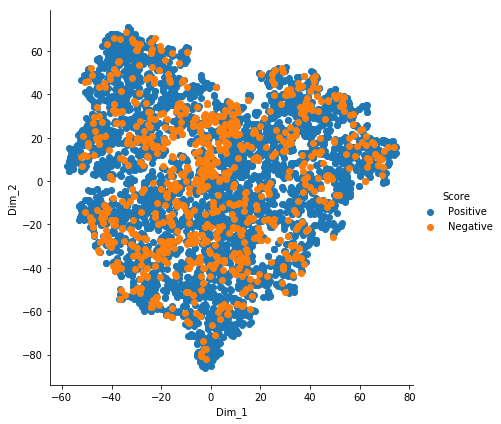

In [20]:
tfidf_w2vs_tsne = TSNE(n_components = 2, random_state = 0).fit_transform(tfidf_w2vs)
label = final_data['Score']
tsne_data = np.vstack((tfidf_w2vs_tsne.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'Score'))
sns.FacetGrid(tsne_df, hue = 'Score', size = 6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()